In [1]:
%autosave 0

Autosave disabled


In [2]:
from abc import abstractmethod
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Any
import types
import seaborn as sns

%matplotlib inline

In [3]:
class BaseFunc:
    @abstractmethod
    def predict(self, data):
        pass

    @abstractmethod
    def derivative(self, data) -> np.matrix:
        pass

    def parameters(self):
        return self._parameters

    def update_parameters(self, new_parameters):
        # print("New par shape: ", new_parameters.shape)
        self._parameters = new_parameters

In [4]:
class LossFunc:
    @abstractmethod
    def loss_value(self, prediction, ground_truth) -> Any:
        pass

    @abstractmethod
    def loss_derivative(self, prediction, ground_truth, parameters=None) -> Any:
        pass

In [5]:
class Model:
    def __init__(
        self,
        base_func: BaseFunc,
        loss_func: LossFunc,
        learning_rate,
        regularization_derivative=lambda x: np.zeros(x.shape),
    ) -> None:
        self.base_func = base_func
        self.loss_func = loss_func
        self.learning_rate = learning_rate
        self.regularization_derivative = regularization_derivative

        assert (
            regularization_derivative(self.base_func.parameters())
            is not types.FunctionType
        ), "This should not be a function"

    def train(self, epochs_num, data, labels, loss_at_epoch=None):
        for i in range(epochs_num):
            prediction = self.base_func.predict(data)
            # print(prediction.shape)

            reg_derivative = self.regularization_derivative(self.base_func.parameters())

            assert (
                reg_derivative.shape == self.base_func.parameters().shape
            ), f"""This should not happen: reg_derivative.shape: {reg_derivative.shape} != 
                parameters_shape: {self.base_func.parameters().shape}"""

            # print(reg_derivative.shape)
            gradient = (
                self.base_func.derivative(data).T
                @ self.loss_func.loss_derivative(prediction, labels)
                + reg_derivative
            )
            # print(
            #     f"bsd: {self.base_func.derivative(data).T.shape}, lsd: {self.loss_func.loss_derivative(prediction, labels).shape}, reg_der: {reg_derivative.shape}"
            # )
            # print("Gradient shape: ", gradient.shape)

            new_parameters = self.base_func.parameters() - self.learning_rate * gradient

            self.base_func.update_parameters(new_parameters)

            if loss_at_epoch is not None:
                loss_at_epoch.append(self.test(data, labels))

            # if (i % 10) == 0:
            #     self.learning_rate *= 0.99

    def test(self, data, labels):
        # print(data.shape)
        prediction = self.base_func.predict(data)
        answer = self.loss_func.loss_value(prediction, labels)
        # print(np.array(answer).shape)
        assert np.array(answer).shape == (), f"Found shape: {np.array(answer).shape}"

        return answer

# Concrete implementations

In [6]:
class OrdinaryBaseFunc(BaseFunc):
    def __init__(self, degree, number_of_inputs) -> None:
        # print(degree)
        self._parameters = np.random.randn(degree)

    def predict(self, data):
        # temp = data @ self._parameters
        # print(self._parameters.shape)

        return data @ self._parameters

    def derivative(self, data):
        return data

In [7]:
class MSE(LossFunc):
    def loss_value(self, prediction, ground_truth):
        return (
            # (1 / (2 * self.number_of_inputs))
            # * (ground_truth - prediction).T
            # @ (ground_truth - prediction)
            (1 / (2 * len(prediction)))
            * (ground_truth - prediction).T
            @ (ground_truth - prediction)
        )

    def loss_derivative(self, prediction, ground_truth, parameters=None):
        # return 1 / self.number_of_inputs * (prediction - ground_truth)
        return 1 / len(prediction) * (prediction - ground_truth)

    def __init__(self, number_of_inputs) -> None:
        self.number_of_inputs = number_of_inputs

In [8]:
class HUBER(LossFunc):
    def loss_value(self, prediction, ground_truth):
        error = ground_truth - prediction
        abs_error = np.abs(error)

        quadratic = 0.5 * np.square(error)
        linear = self.delta * (abs_error - 0.5 * self.delta)

        loss = np.where(abs_error <= self.delta, quadratic, linear)
        return np.mean(loss)

    def loss_derivative(self, prediction, ground_truth, parameters=None):
        error = prediction - ground_truth
        abs_error = np.abs(error)

        gradient = np.where(abs_error <= self.delta, error, self.delta * np.sign(error))
        return gradient / self.number_of_inputs

    def __init__(self, number_of_inputs, delta=1.0):
        self.number_of_inputs = number_of_inputs
        self.delta = delta

In [9]:
def L2_regularization(lambda_coefficient=0.02):
    def L2_reg_func(parameters):
        temp_parameters = np.array(parameters)
        temp_parameters[0] = 0
        return lambda_coefficient * 2 * temp_parameters.T

    return L2_reg_func


def L1_regularization(lambda_coefficient=0.02):
    def L1_reg_func(parameters):
        temp_parameters = np.array(parameters)
        temp_parameters[0] = 0
        return lambda_coefficient * np.sign(temp_parameters)

    return L1_reg_func

# Load and display data

In [10]:
df = pd.read_csv("dane.data", delimiter=r"\s+", header=None, decimal=",")

In [11]:
def divide_data(data, test_ratio):
    # return train_test_split(data, train_size=train_ratio,  random_state=42)
    return train_test_split(data, test_size=test_ratio, random_state=6)
    # return train_test_split(data, train_size=train_ratio, stratify=housing["median_house_value"], random_state=8)


train_set, test_set = divide_data(df, test_ratio=0.2)
train_set, validation_set = divide_data(train_set, test_ratio=0.2 / 0.6)

In [12]:
train_labels = train_set.pop(train_set.columns[7])
validation_labels = validation_set.pop(validation_set.columns[7])
test_labels = test_set.pop(test_set.columns[7])
# train_set.insert(0, "Ones", 1)
train_set.head()

,0,1,2,3,4,5,6
1549,5,-3,5,11,31,-2,17
1503,5,-1,2,37,31,1,13
156,-9,-1,5,8,42,-1,13
824,-2,1,5,20,57,0,9
1944,9,-3,4,9,55,-2,17


In [13]:
train_labels.head()

1549     598.40
1503    1312.93
156      157.59
824     1355.95
1944     701.29
Name: 7, dtype: float64

# Analyze Data

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1999 non-null   int64  
 1   1       1999 non-null   int64  
 2   2       1999 non-null   int64  
 3   3       1999 non-null   int64  
 4   4       1999 non-null   int64  
 5   5       1999 non-null   int64  
 6   6       1999 non-null   int64  
 7   7       1999 non-null   float64
dtypes: float64(1), int64(7)
memory usage: 125.1 KB


In [15]:
df.describe()

,0,1,2,3,4,5,6,7
count,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000
mean,-0.393697,-0.566783,4.534267,18.230115,44.667834,-1.002001,12.133567,972.433012
std,5.719554,2.870306,1.710739,12.076917,8.591131,1.427948,5.740612,537.603977
min,-10.000000,-5.000000,2.000000,-2.000000,30.000000,-3.000000,3.000000,-238.060000
25%,-5.000000,-3.000000,3.000000,8.000000,37.000000,-2.000000,7.000000,500.105000
50%,0.000000,-1.000000,5.000000,18.000000,45.000000,-1.000000,13.000000,949.580000
75%,5.000000,2.000000,6.000000,29.000000,52.000000,0.000000,17.000000,1363.160000
max,9.000000,4.000000,7.000000,39.000000,59.000000,1.000000,21.000000,2718.900000


In [16]:
df_copy = df.copy()
cols_num = len(df_copy.columns)

new_columns = {}

for exponent in range(2, 6):
    for i in range(cols_num - 1):
        new_columns[f"feature_{i}_exp_{exponent}"] = df_copy.iloc[:, i] ** exponent

# for left in range(cols_num - 1):
#     for right in range(left + 1, cols_num - 1):
#         new_columns[f"f_{left} + f_{right}"] = df_copy.iloc[:, left] + df_copy.iloc[:, right]

for exponent in range(1, 3):
    for left in range(cols_num - 1):
        for right in range(left + 1, cols_num - 1):
            new_columns[f"f_{left}^{exponent} * f_{right}"] = (
                df_copy.iloc[:, left] ** exponent * df_copy.iloc[:, right]
            )
            if exponent > 1:
                new_columns[f"f_{left} * f_{right}^{exponent}"] = (
                    df_copy.iloc[:, left] * df_copy.iloc[:, right] ** exponent
                )

for first in range(cols_num - 1):
    for second in range(first + 1, cols_num - 1):
        for third in range(second + 1, cols_num - 1):
            new_columns[f"f_{first} * f_{second} * f_{third}"] = (
                df_copy.iloc[:, first]
                * df_copy.iloc[:, second]
                * df_copy.iloc[:, third]
            )


base_col = df.iloc[:, 3]
mean_3 = np.mean(base_col.to_numpy())
powers = [1 / 10, 1 / 20, 1 / 100]
powers += range(1, 100)
temp = pd.DataFrame(
    {
        f"exp -([3]-mean[3])^2/{s}^2": np.exp(-((base_col - mean_3) ** 2) / (s**2))
        for s in powers
    }
)

df_copy = pd.concat([df_copy, pd.DataFrame(new_columns), temp], axis=1)
cols_num = len(df_copy.T)
print(cols_num)

corr_matrix = df_copy.corr()
# # corr_matrix = corr_matrix[abs(corr_matrix[1]) >= 0.05]
pd.set_option("display.max_rows", 200)

correlations = corr_matrix[7]
correlations = correlations[abs(correlations) > 0.25]
correlations.sort_values(ascending=False)

236


7                  1.000000
f_3^1 * f_4        0.934055
f_3 * f_4^2        0.912975
f_3^2 * f_4        0.906840
3                  0.867767
feature_3_exp_2    0.847247
feature_3_exp_3    0.802864
f_2 * f_3 * f_4    0.779805
feature_3_exp_4    0.761175
f_2 * f_3^2        0.744624
f_3 * f_4 * f_6    0.734175
feature_3_exp_5    0.725373
f_2^1 * f_3        0.715264
f_3^2 * f_6        0.712603
f_3^1 * f_6        0.669817
f_2 * f_3 * f_6    0.577972
f_2^2 * f_3        0.550614
f_3 * f_6^2        0.508773
f_1^2 * f_3        0.441636
f_0^2 * f_3        0.415215
f_3 * f_5^2        0.383960
f_0 * f_2^2        0.319429
f_0^1 * f_2        0.313455
f_0 * f_2 * f_4    0.300624
4                  0.299800
feature_4_exp_2    0.298828
f_0 * f_2 * f_6    0.296200
feature_4_exp_3    0.295995
feature_4_exp_4    0.291756
feature_4_exp_5    0.286567
0                  0.276799
f_0^1 * f_6        0.267960
f_0^1 * f_4        0.264925
f_0 * f_4 * f_6    0.256588
feature_0_exp_3    0.253670
f_3 * f_5 * f_6   -0

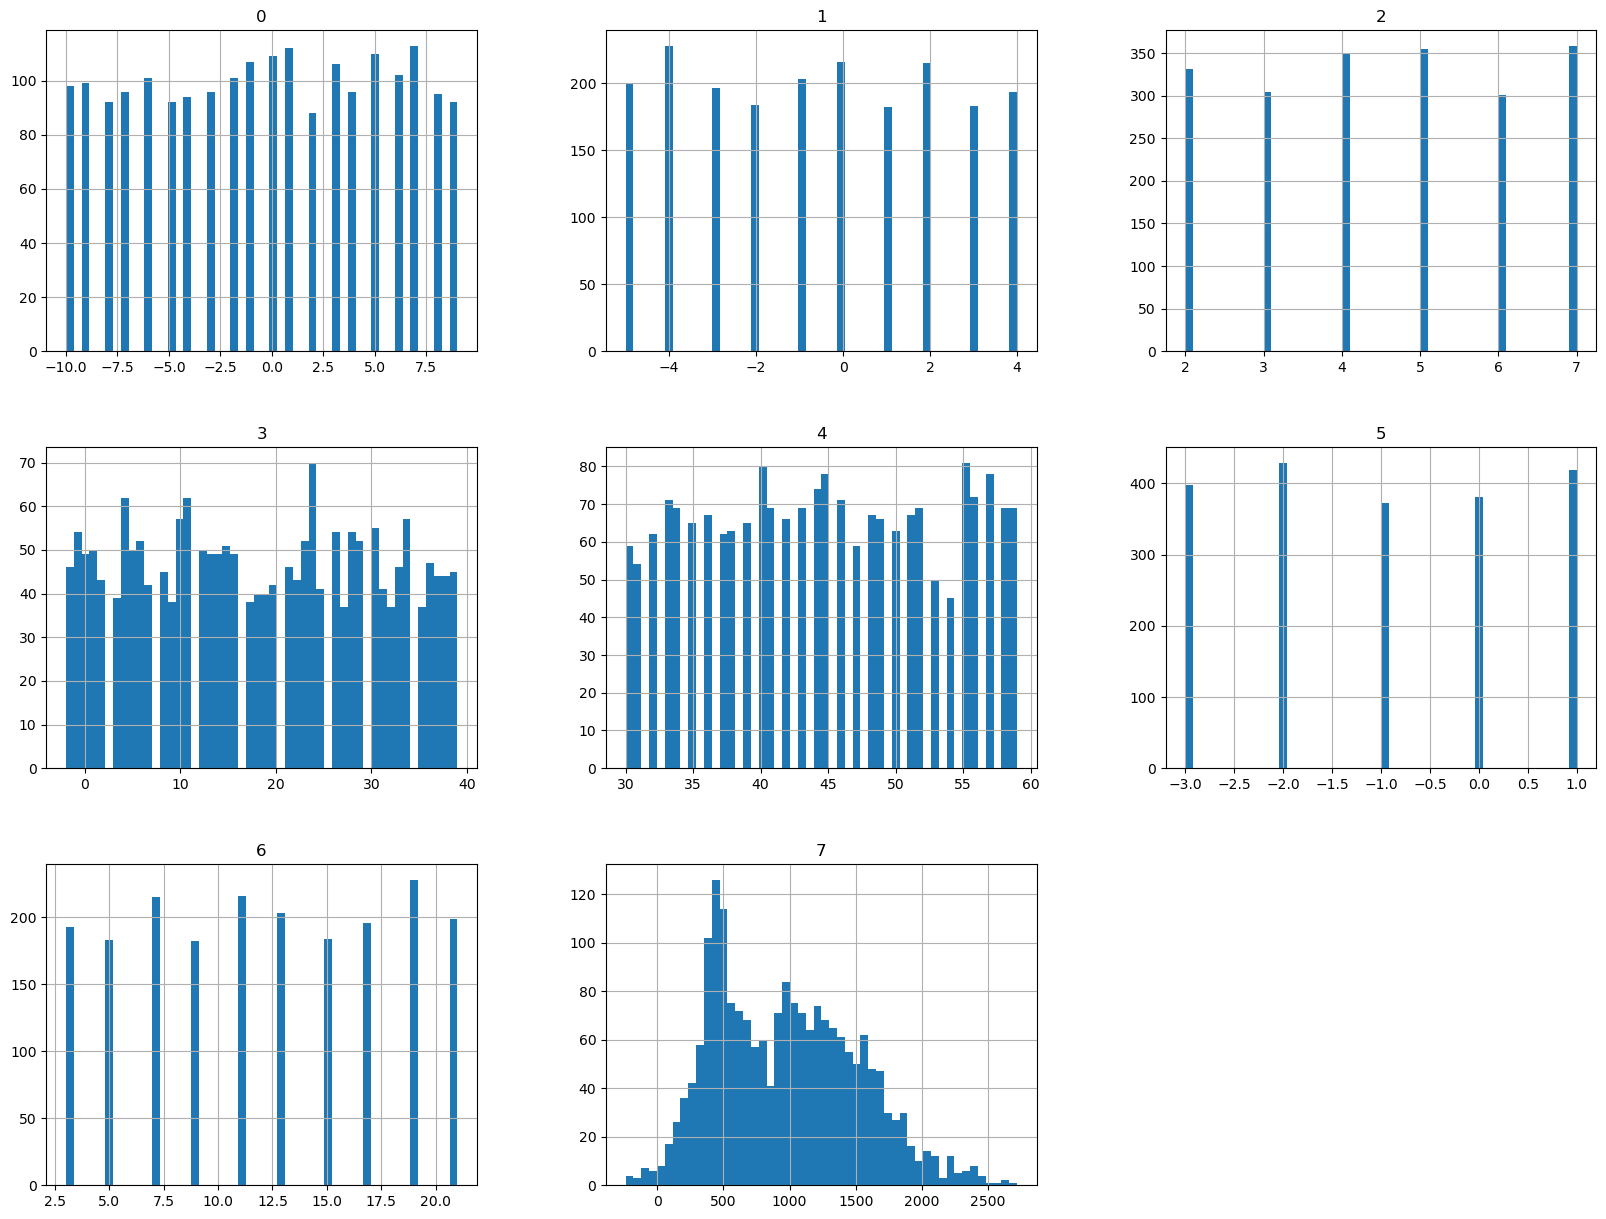

In [17]:
pd.reset_option("display.max_rows")
df.hist(bins=50, figsize=(20, 15))
plt.show()

In [18]:
def standarize_matrix_and_add_ones(data_matrix):
    mean = np.mean(data_matrix, axis=0)
    std = np.std(data_matrix, axis=0)
    std[std == 0] = 1

    standarized = (data_matrix - mean) / std
    return np.c_[np.ones(standarized.shape[0]), standarized]

In [19]:
def to_matrices(data, labels, preprocess_func=lambda x: x):
    return preprocess_func(data.to_numpy()), labels.to_numpy()


train_matrix, train_labels_matrix = to_matrices(
    train_set, train_labels, standarize_matrix_and_add_ones
)


print(train_matrix[:6])
print(train_matrix.shape)
print(train_labels_matrix.shape)

[[ 1.          0.93009054 -0.85396457  0.26424844 -0.57262352 -1.56020811
  -0.70065979  0.85396457]
 [ 1.          0.93009054 -0.15275234 -1.48011885  1.59201065 -1.56020811
   1.41522682  0.15275234]
 [ 1.         -1.49686955 -0.15275234  0.26424844 -0.822389   -0.27818258
   0.00463575  0.15275234]
 [ 1.         -0.2833895   0.5484599   0.26424844  0.17667292  1.47003405
   0.70993128 -0.5484599 ]
 [ 1.          1.62350771 -0.85396457 -0.31720732 -0.73913384  1.2369385
  -0.70065979  0.85396457]
 [ 1.          0.58338195 -0.50335845  1.42715997 -1.40517513 -0.86092145
   0.70993128  0.50335845]]
(1065, 8)
(1065,)


In [20]:

validation_matrix, validation_labels_matrix = to_matrices(
    validation_set, validation_labels, standarize_matrix_and_add_ones
)
test_matrix, test_labels_matrix = to_matrices(
    test_set, test_labels, standarize_matrix_and_add_ones
)

print(test_matrix.shape, test_labels_matrix.shape)

# test_set

(400, 8) (400,)


# Plot results

In [21]:
def train_and_test(
    model,
    train_matrix,
    train_labels_matrix,
    test_matrix,
    test_labels_matrix,
    epochs_num=700,
):
    loss_at_epochs = [model.test(train_matrix, train_labels_matrix)]
    model.train(epochs_num, train_matrix, train_labels_matrix, loss_at_epochs)
    print(model.test(train_matrix, train_labels_matrix))
    print(model.test(test_matrix, test_labels_matrix))

    plt.plot(range(len(loss_at_epochs)), loss_at_epochs, marker="o", linewidth=0.0025)
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title("Loss at epochs")
    plt.grid(True)
    plt.show()

# Ordinary model

In [22]:
base_func = OrdinaryBaseFunc(train_matrix.shape[1], train_matrix.shape[0])
loss_func = MSE(train_matrix.shape[0])

model = Model(base_func, loss_func, 0.01)

14781.871246694474
14551.9691115352


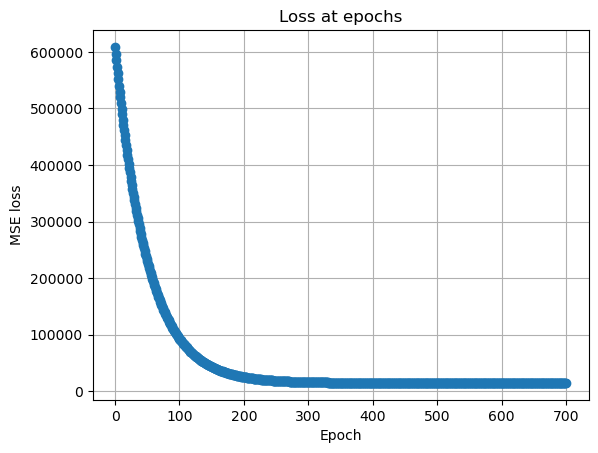

In [23]:
train_and_test(
    model,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
)

# Ordinary with L2 regularization

In [24]:
base_func_reg_L2 = OrdinaryBaseFunc(train_matrix.shape[1], train_matrix.shape[0])
loss_func_reg_L2 = MSE(train_matrix.shape[0])


model = Model(base_func_reg_L2, loss_func_reg_L2, 0.01, L2_regularization())

14966.832525568858
15141.45022436689


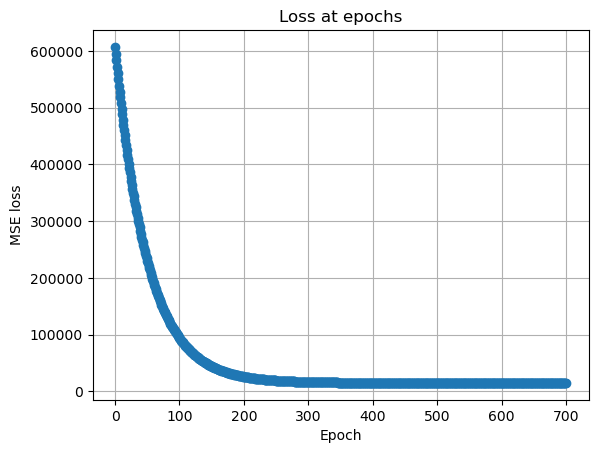

In [25]:
train_and_test(
    model,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
)

# Ordinary with L1 regularization

In [26]:
lambda_coefficient = 10
base_func_reg_L1 = OrdinaryBaseFunc(train_matrix.shape[1], train_matrix.shape[0])
loss_func_reg_L1 = MSE(train_matrix.shape[0])


model = Model(base_func_reg_L1, loss_func_reg_L1, 0.01, L1_regularization())

14781.880216500394
14552.83011069959


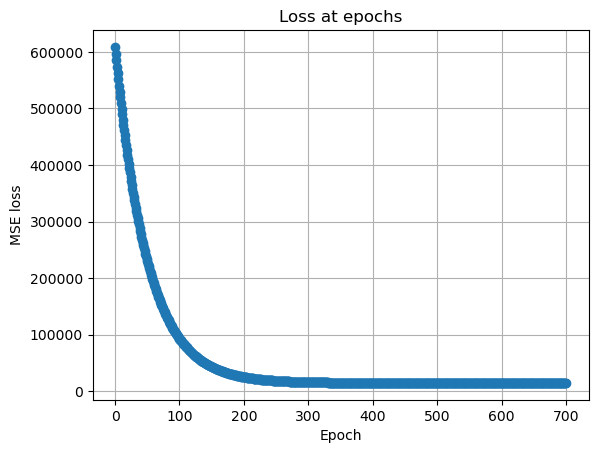

In [27]:
train_and_test(
    model,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
)

# First Hypothesis

In [28]:
def test_hypothesis(
    preprocess_matrix_func,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
    test_matrix,
    test_labels_matrix,
    epochs_num=700,
    regularization_derivative=None,
):
    train_matrix_hyp = preprocess_matrix_func(train_matrix)
    validation_matrix_hyp = preprocess_matrix_func(validation_matrix)
    test_matrix_hyp = preprocess_matrix_func(test_matrix)
    base_func_hyp = OrdinaryBaseFunc(
        train_matrix_hyp.shape[1], train_matrix_hyp.shape[0]
    )
    loss_func_hyp = MSE(train_matrix_hyp.shape[0])
    model = None
    if regularization_derivative is None:
        model = Model(base_func_hyp, loss_func_hyp, 0.01)
    else:
        model = Model(base_func_hyp, loss_func_hyp, 0.01, regularization_derivative)

    train_and_test(
        model,
        train_matrix_hyp,
        train_labels_matrix,
        validation_matrix_hyp,
        validation_labels_matrix,
        epochs_num,
    )

    return model

35449.03398449967
38387.323754830715


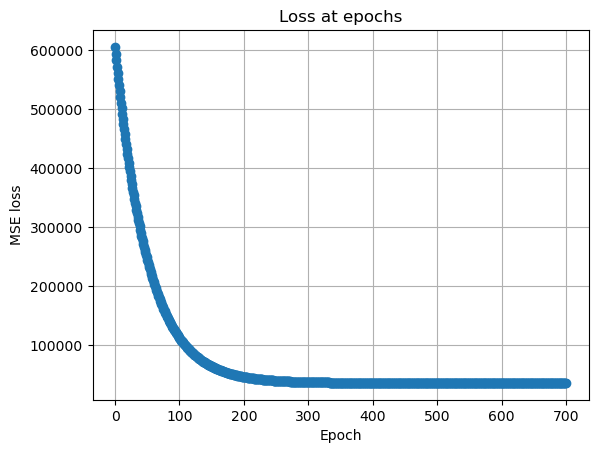

In [29]:
def preprocess_data_matrix_1(data_matrix):
    answer = data_matrix[:, [0, 4]]
    return answer


test_hypothesis(
    preprocess_data_matrix_1,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
    test_matrix,
    test_labels_matrix,
)

# Second Hypothesis

23847.61578666104
24611.933357749593


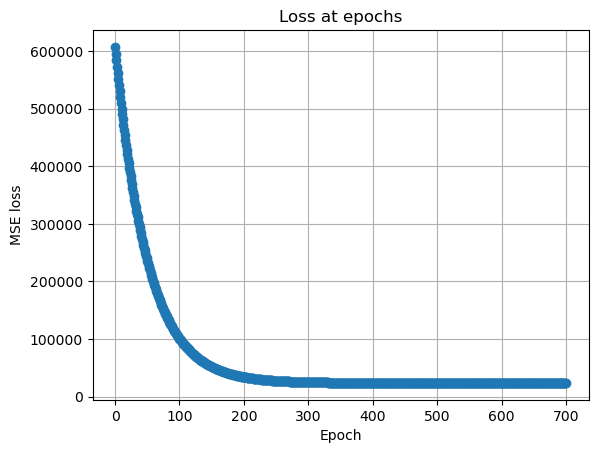

In [30]:
def preprocess_data_matrix_2(data_matrix):
    answer = data_matrix[:, [0, 4, 5]]
    return answer


test_hypothesis(
    preprocess_data_matrix_2,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
    test_matrix,
    test_labels_matrix,
)

# Third Hypothesis

17920.897315362643
20043.32738303981


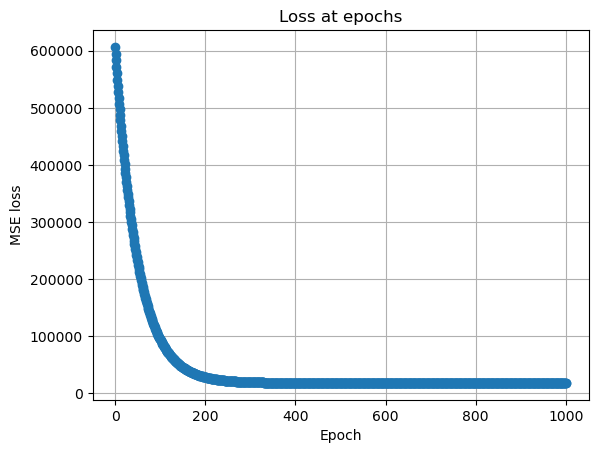

In [31]:
def preprocess_data_matrix_3(data_matrix):
    answer = np.column_stack(
        (
            data_matrix[:, 0],
            data_matrix[:, 3 + 1],
            data_matrix[:, 4 + 1],
            data_matrix[:, 3 + 1] * data_matrix[:, 4 + 1],
        )
    )
    # print(answer.shape)
    return answer


test_hypothesis(
    preprocess_data_matrix_3,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
    test_matrix,
    test_labels_matrix,
    1000,
)

8314.147549903622
10211.150326001098


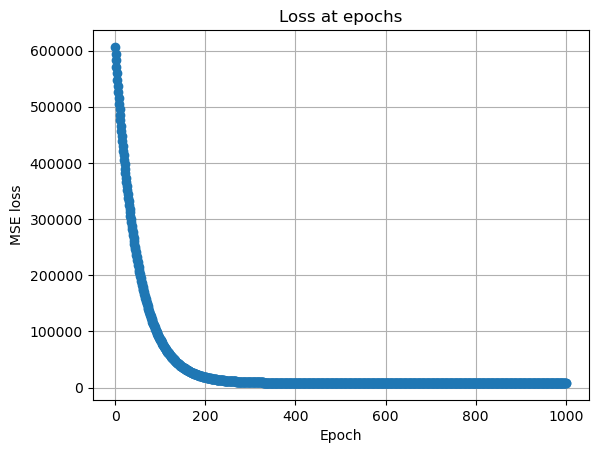

9787.81184937308


In [32]:
def preprocess_data_matrix_4(data_matrix):
    answer = np.column_stack(
        (
            data_matrix[:, 0],
            data_matrix[:, 1],
            data_matrix[:, 3 + 1],
            data_matrix[:, 4 + 1],
            data_matrix[:, 3 + 1] * data_matrix[:, 4 + 1],
        )
    )
    # print(answer.shape)
    return answer


model = test_hypothesis(
    preprocess_data_matrix_4,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
    test_matrix,
    test_labels_matrix,
    1000,
)

print(model.test(preprocess_data_matrix_4(test_matrix), test_labels_matrix))

14822.040495353585
14647.463136179791


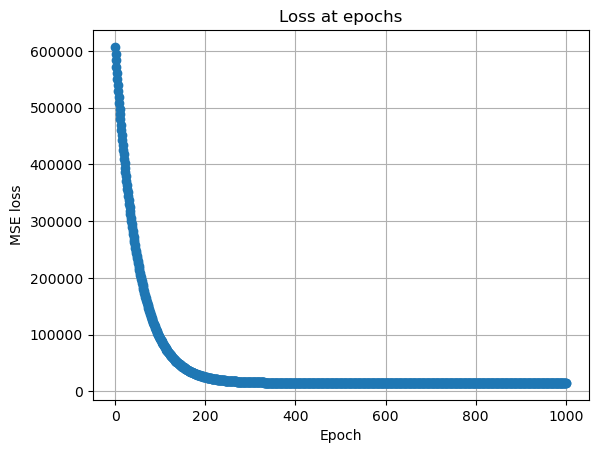

In [33]:
def preprocess_data_matrix_5(data_matrix):
    answer = np.column_stack(
        (data_matrix[:, 0], data_matrix[:, 1], data_matrix[:, 4], data_matrix[:, 5])
    )
    # print(answer.shape)
    return answer


model = test_hypothesis(
    preprocess_data_matrix_5,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
    test_matrix,
    test_labels_matrix,
    1000,
)


# print(model.test(preprocess_data_matrix_4(test_matrix), test_labels_matrix))

111589.56279271608
123779.5201701903


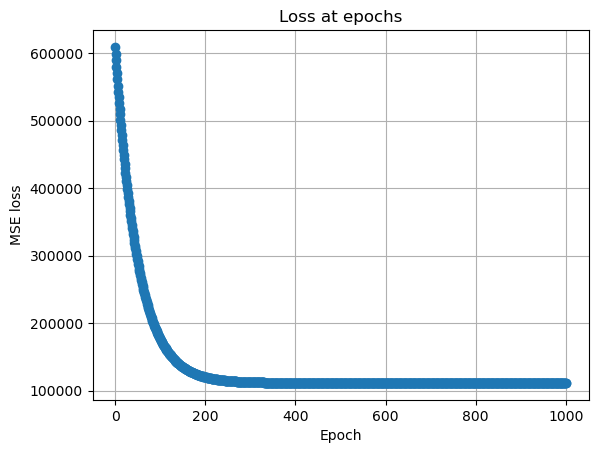

In [34]:
def preprocess_data_matrix_6(data_matrix):
    answer = np.column_stack(
        (
            data_matrix[:, 0],
            data_matrix[:, 1],
            data_matrix[:, 5],
            data_matrix[:, 4] * data_matrix[:, 5],
        )
    )
    # print(answer.shape)
    return answer


model = test_hypothesis(
    preprocess_data_matrix_6,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
    test_matrix,
    test_labels_matrix,
    1000,
)

127265.10964026602
129447.09124159616


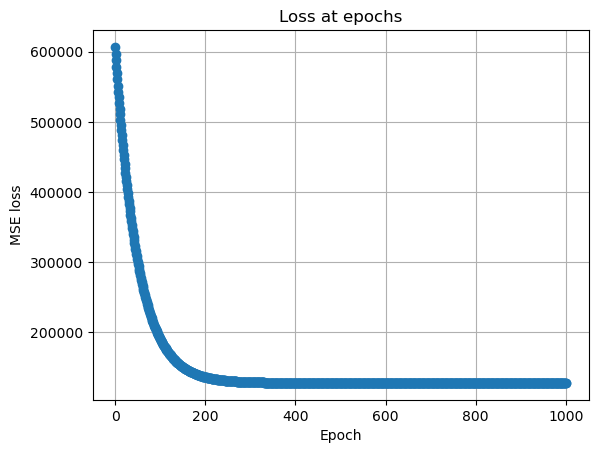

In [35]:
def preprocess_data_matrix_7(data_matrix):
    answer = np.column_stack(
        (data_matrix[:, 0], data_matrix[:, 1], data_matrix[:, 4] * data_matrix[:, 5])
    )
    # print(answer.shape)
    return answer


model = test_hypothesis(
    preprocess_data_matrix_7,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
    test_matrix,
    test_labels_matrix,
    1000,
)

137882.49783781657
141958.11336409257


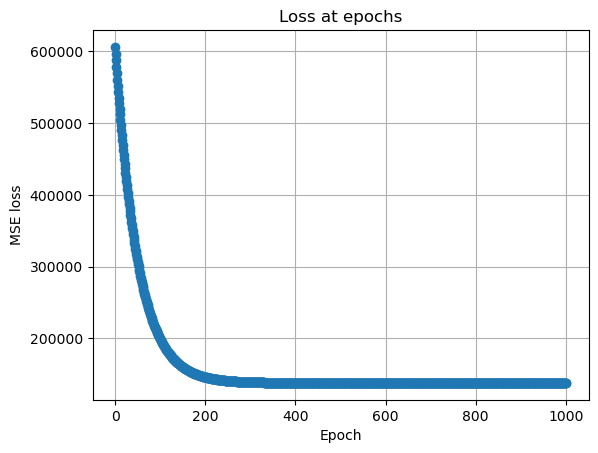

In [36]:
def preprocess_data_matrix_8(data_matrix):
    answer = np.column_stack((data_matrix[:, 0], data_matrix[:, 4] * data_matrix[:, 5]))
    # print(answer.shape)
    return answer


model = test_hypothesis(
    preprocess_data_matrix_8,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
    test_matrix,
    test_labels_matrix,
    1000,
)

# Best hyphothesis with regularization

8314.14828053909
10211.333659861513


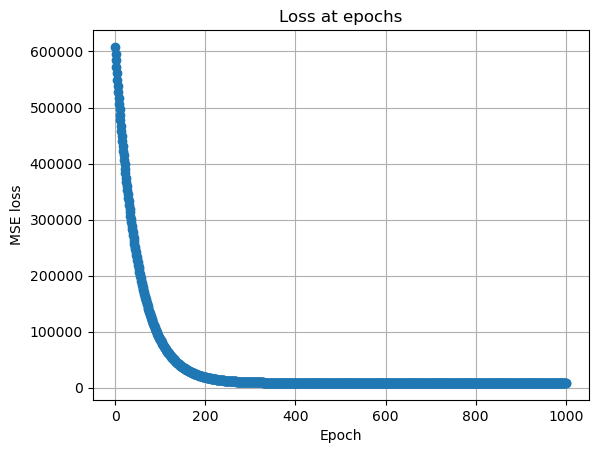

9787.107710045731

8502.964860575437
10692.588119436656


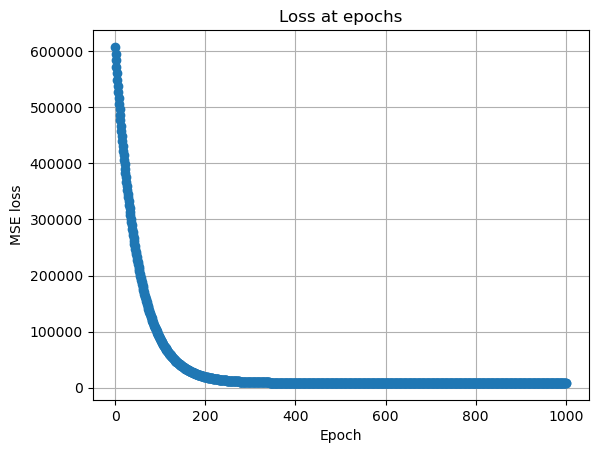

9898.109836326978


In [37]:
model = test_hypothesis(
    preprocess_data_matrix_4,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
    test_matrix,
    test_labels_matrix,
    1000,
    L1_regularization(),
)

print(model.test(preprocess_data_matrix_4(test_matrix), test_labels_matrix), end="\n\n")

model = test_hypothesis(
    preprocess_data_matrix_4,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
    test_matrix,
    test_labels_matrix,
    1000,
    L2_regularization(),
)

print(model.test(preprocess_data_matrix_4(test_matrix), test_labels_matrix))

# Adding parameters to best hyphothesis

7915.343071312174
9639.156210964256


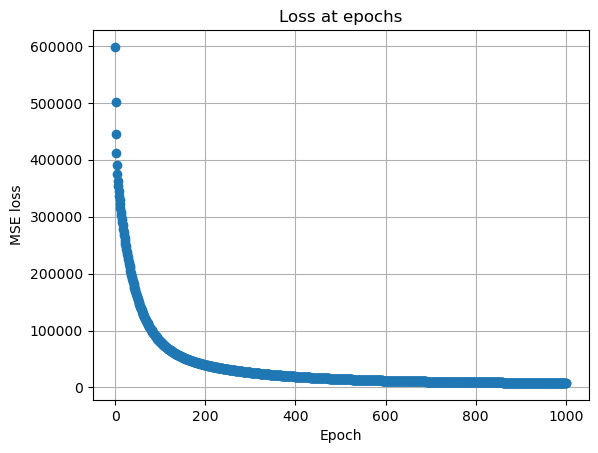

In [38]:
threshold = 1e-8


def preprocess_data_matrix_9(data_matrix):
    answer = np.column_stack(
        (
            data_matrix[:, 0],
            data_matrix[:, 1],
            # data_matrix[:, 1] ** 2,
            # data_matrix[:, 1] ** 3,
            # data_matrix[:, 2],
            # data_matrix[:, 3],
            # data_matrix[:, 6],
            # data_matrix[:, 7],
            data_matrix[:, 4],
            data_matrix[:, 4] ** 2,
            data_matrix[:, 4] ** 3,
            data_matrix[:, 4] ** 4,
            data_matrix[:, 4] ** 5,
            data_matrix[:, 4] ** 6,
            # data_matrix[:, 4] ** 7,
            np.where(data_matrix[:, 4] ** 7 < threshold, 0, data_matrix[:, 4] ** 7),
            # np.where(data_matrix[:, 4] ** 8 < threshold, 0, data_matrix[:, 4] ** 8),
            data_matrix[:, 5],
            # data_matrix[:, 5] ** 2,
            # data_matrix[:, 5] ** 3,
            data_matrix[:, 4] * data_matrix[:, 5],
            # data_matrix[:, 1] * data_matrix[:, 5]
            # data_matrix[:, 4] * data_matrix[:, 1]
            # data_matrix[:, 4] * data_matrix[:, 5] * data_matrix[:, 0]
        )
    )
    # print(answer.shape)
    return answer


model = test_hypothesis(
    preprocess_data_matrix_9,
    train_matrix,
    train_labels_matrix,
    validation_matrix,
    validation_labels_matrix,
    test_matrix,
    test_labels_matrix,
    1000,
    # L1_regularization(),
)

# Korekta błędu myślowego

In [39]:
def new_test_hypothesis(
    preprocess_data_func,
    train_data,
    train_labels,
    validation_data,
    validation_labels,
    epochs_num=700,
    regularization_derivative=None,
):
    train_matrix_hyp = preprocess_data_func(train_data)
    validation_matrix_hyp = preprocess_data_func(validation_data)
    base_func_hyp = OrdinaryBaseFunc(
        train_matrix_hyp.shape[1], train_matrix_hyp.shape[0]
    )
    loss_func_hyp = MSE(train_matrix_hyp.shape[0])
    model = None
    if regularization_derivative is None:
        model = Model(base_func_hyp, loss_func_hyp, 0.01)
    else:
        model = Model(base_func_hyp, loss_func_hyp, 0.01, regularization_derivative)

    train_labels_matrix = train_labels.to_numpy()
    validation_labels = validation_labels.to_numpy()
    train_and_test(
        model,
        train_matrix_hyp,
        train_labels_matrix,
        validation_matrix_hyp,
        validation_labels_matrix,
        epochs_num,
    )

    return model

7430.6178598982715
8729.584866389925


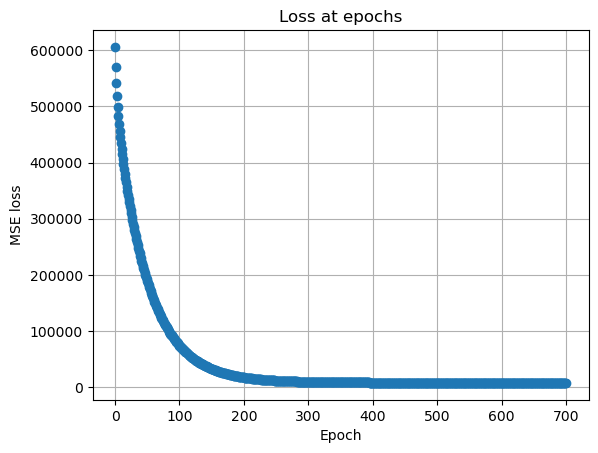

7339.663275077944
Test error std:  117.36458389046805


In [40]:
# def preprocess_data_best_model(data_df: pd.DataFrame):
def preprocess_data_best_model(data_df):
    data_copy = data_df.copy()
    columns = pd.DataFrame()
    columns[0] = data_copy[0]
    columns[3] = data_copy[3]
    columns[4] = data_copy[4]
    columns["[3]*[4]"] = data_copy.iloc[:, 3] * data_copy.iloc[:, 4]
    powers = range(2, 200)

    # base_col = data_copy.iloc[:, 0]
    # temp = pd.DataFrame({f"[0]^{i}": base_col**i for i in powers})
    # columns = pd.concat([columns, temp], axis=1)

    base_col = data_copy.iloc[:, 3]
    temp = pd.DataFrame({f"[3]^{i}": base_col**i for i in powers})
    columns = pd.concat([columns, temp], axis=1)

    # base_col = data_copy.iloc[:, 4]
    # temp = pd.DataFrame({f"[4]^{i}": base_col**i for i in powers})
    # columns = pd.concat([columns, temp], axis=1)

    assert len(columns.T) > 200, "Columns were not added"
    return standarize_matrix_and_add_ones(columns.to_numpy())


model = new_test_hypothesis(
    preprocess_data_best_model,
    train_set,
    train_labels,
    validation_set,
    validation_labels,
)


test_matrix = preprocess_data_best_model(test_set)
print(model.test(test_matrix, test_labels.to_numpy()))

test_error = model.base_func.predict(test_matrix) - test_labels
print("Test error std: ", np.std(test_error))

5435.469816726256
5532.941658739732


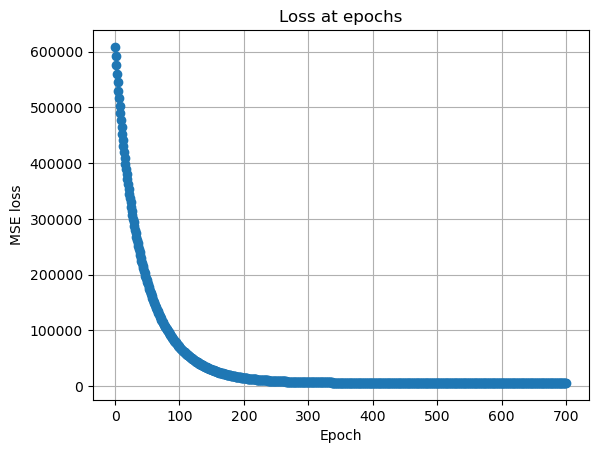

5376.516504715693


In [41]:
def preprocess_data_exponent3(data_df):
    data_copy = data_df.copy()
    columns = pd.DataFrame()
    columns[0] = data_copy[0]
    columns[3] = data_copy[3]
    columns[4] = data_copy[4]

    prod_of34 = data_copy.iloc[:, 3] * data_copy.iloc[:, 4]
    # prod_of34 = np.array(data_copy.iloc[:, 3] * data_copy.iloc[:, 4]).astype(np.float64)
    # prod_of34[prod_of34 == 0] = 1e-9
    powers = [1, 2]
    temp = pd.DataFrame({f"([3]*[4])**{i}": np.pow(prod_of34, i) for i in powers})
    columns = pd.concat([columns, temp], axis=1)

    base_col = data_copy.iloc[:, 3]

    # powers = [0.5, 0.25, 0.05]
    powers = []
    powers += range(1, 10)
    powers += range(20, 24)
    # powers += range(60, 68)
    mean_3 = np.mean(base_col.to_numpy())
    temp = pd.DataFrame(
        {
            f"exp -([3]-mean[3])^2/{s}^2": np.exp(-((base_col - mean_3) ** 2) / (s**2))
            for s in powers
        }
    )
    columns = pd.concat([columns, temp], axis=1)
    # print(mean_3)

    # powers = []
    # powers += range(1, 100)
    # mean_of_prod34 = np.mean(prod_of34.to_numpy())
    # temp = pd.DataFrame(
    #     {
    #         f"exp -([3]-mean[3])^2/{s}^2": np.exp(
    #             -((prod_of34 - mean_of_prod34) ** 2) / (s**2)
    #         )
    #         for s in powers
    #     }
    # )
    # columns = pd.concat([columns, temp], axis=1)

    # powers = []
    # powers += range(1, 100)
    # mean_of_4 = np.mean(data_copy.iloc[:, 4])
    # temp = pd.DataFrame(
    #     {
    #         f"exp -([3]-mean[3])^2/{s}^2": np.exp(
    #             -((data_copy.iloc[:, 4] - mean_of_4) ** 2) / (s**2)
    #         )
    #         for s in powers
    #     }
    # )
    # columns = pd.concat([columns, temp], axis=1)

    # print(mean_3)
    return standarize_matrix_and_add_ones(columns.to_numpy())


model = new_test_hypothesis(
    preprocess_data_exponent3,
    train_set,
    train_labels,
    validation_set,
    validation_labels,
    700,
    # L1_regularization(),
)

test_matrix = preprocess_data_exponent3(test_set)
print(model.test(test_matrix, test_labels.to_numpy()))

# Experiments

In [42]:
def ultimate_test_hypothesis(
    preprocess_data_func,
    train_data,
    train_labels,
    validation_data,
    validation_labels,
    model,
    epochs_num=700,
):
    train_matrix_hyp = preprocess_data_func(train_data)
    validation_matrix_hyp = preprocess_data_func(validation_data)

    train_labels_matrix = train_labels.to_numpy()
    validation_labels = validation_labels.to_numpy()
    train_and_test(
        model,
        train_matrix_hyp,
        train_labels_matrix,
        validation_matrix_hyp,
        validation_labels_matrix,
        epochs_num,
    )

    return model

# Huber loss

5302.061773490819
5446.722299852876


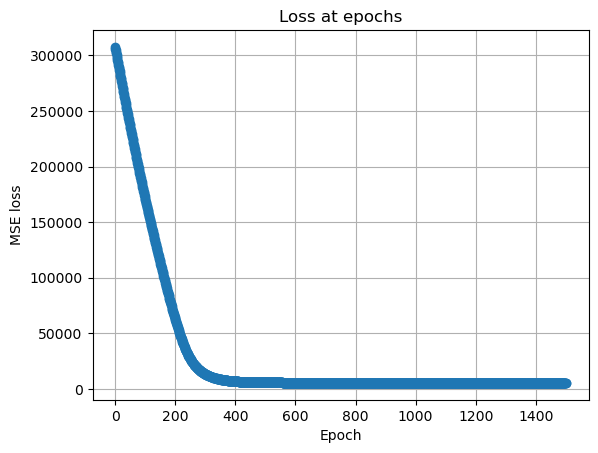

MSE validation:  5446.722299852876

Train error std:  102.97647198905703
Validation errors:
 85      331.215787
268     290.144546
86      287.954944
186     278.278139
184     264.695369
           ...    
1905   -251.046646
1898   -258.498820
1993   -266.086604
1994   -272.258146
1991   -279.856648
Name: 7, Length: 534, dtype: float64 



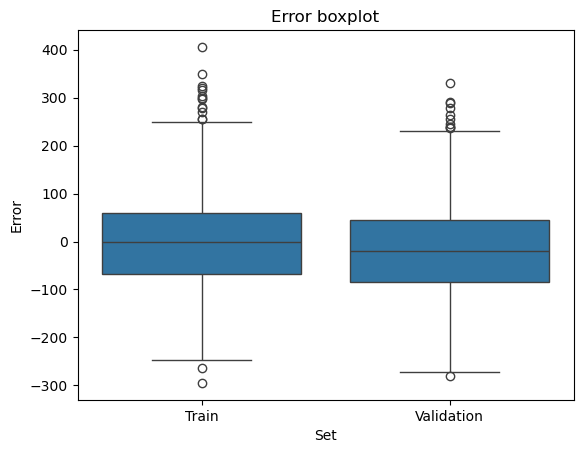

In [43]:
# delta = 1e20
# epochs_num = 700
delta = 400.0
epochs_num = 1500
train_matrix_hyp = preprocess_data_exponent3(train_set)
validation_matrix_hyp = preprocess_data_exponent3(validation_set)
test_matrix_hyp = preprocess_data_exponent3(test_set)

base_func_hyp = OrdinaryBaseFunc(train_matrix_hyp.shape[1], train_matrix_hyp.shape[0])
loss_func_hyp = HUBER(train_matrix_hyp.shape[0], delta)
# reg_parameter = 0.8
# model = Model(base_func_hyp, loss_func_hyp, 0.01, L1_regularization(reg_parameter))
model = Model(base_func_hyp, loss_func_hyp, 0.01)
# reg_parameter = 0.00001
# model = Model(base_func_hyp, loss_func_hyp, 0.01, L2_regularization(reg_parameter))
train_and_test(
    model,
    train_matrix_hyp,
    train_labels_matrix,
    validation_matrix_hyp,
    validation_labels_matrix,
    epochs_num,
)

# print("Huber loss: ", model.test(test_matrix, test_labels.to_numpy()))
model.loss_func = MSE(train_matrix_hyp.shape[0])
print(
    "MSE validation: ",
    model.test(validation_matrix_hyp, validation_labels.to_numpy()),
    end="\n\n",
)
# print("MSE: ", model.test(test_matrix_hyp, test_labels.to_numpy()))

train_error = model.base_func.predict(train_matrix_hyp) - train_labels
print("Train error std: ", np.std(train_error))
validation_error = model.base_func.predict(validation_matrix_hyp) - validation_labels

# plt.boxplot(
#     [train_error, validation_error], tick_labels=["Train errors", "Validation errors"]
# )
# plt.title("Error boxplot")
# plt.show()

print("Validation errors:\n", validation_error.sort_values(ascending=False), "\n")
error_df = pd.DataFrame(
    {
        "Error": pd.concat([train_error, validation_error], ignore_index=True),
        "Set": ["Train"] * len(train_error) + ["Validation"] * len(validation_error),
    }
)

# Plot with seaborn
sns.boxplot(x="Set", y="Error", data=error_df)
plt.title("Error boxplot")
# plt.grid(True)
plt.show()